# Multi-armed Bandits

> Guided by [Sutton, R. and Barto, A. (2018). Reinforcement Learning: An Introduction. 2nd ed. Cambridge, MA: MIT Press, pp.25-45. Chapter 2.](http://incompleteideas.net/book/the-book-2nd.html)

*Exercise 2.5 (programming)* Design and conduct an experiment to demostrate the difficulties that sample-average methods have for nonstationary problems. Use a modified version of the 10-armed testbed in which all the $q_*(a)$ start out equal and then take independent random walks (say by adding a normally distributed increment with mean zero and standard deviation 0.01 to all the $q_*(a)$ on each step). Prepare plots for an action-value method using sample averages, incrementally computed, and another action-value method using a constant step-size parameter, $\alpha = 0.1$. Use $\epsilon = 0.1$ and longer runs, say of 10,000 steps.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import multiprocessing

In [2]:
k = 10
variance = 0.01
walk_mean = 0
walk_std = 0.01

step_size = 0.1
epsilon = 0.1

steps = 10000
runs = 2000


def choose_greedy(estimates):
    max_is = np.argwhere(estimates == np.amax(estimates)).flatten() # get indices of largest estimates
    return np.random.choice(max_is)


def choose_random(estimates):
    return np.random.choice(np.size(estimates))


def get_reward(means, index, variance):
    mean = means[index]
    return np.random.normal(mean, 1)


def walk(means, walk_mean, walk_std):
    return means + np.random.normal(walk_mean, walk_std, np.shape(means))


def update_estimate_sample_average(estimates, index, step, reward):
    estimates[index] = estimates[index] + 1.0 / step * (reward - estimates[index])
    return estimates


def update_estimate_constant_step_size(estimates, index, step_size, reward):
    estimates[index] = estimates[index] + step_size * (reward - estimates[index])
    return estimates


def is_optimal(means, index):
    return index in np.argwhere(means == np.amax(means)).flatten()

In [3]:
# sample average
def run_sample_average(_):
    rewards_run = []
    is_optimals_run = []
    
    testbed_mean = np.zeros(k) # initialize testbed, $q_1(a) = 0$
    testbed_estimate = np.zeros(k) # initialize estimations, $Q_1(a) = 0$
    
    for step in range(1, steps + 1):
        if np.random.choice(2, p=[1 - epsilon, epsilon]): # randomly choose, 0: random, 1: greedy
            index = choose_random(testbed_estimate)
        else:
            index = choose_greedy(testbed_estimate)
            
        is_optimals_run.append(is_optimal(testbed_mean, index))
            
        reward = get_reward(testbed_mean, index, variance)
        rewards_run.append(reward)
        
        testbed_estimate = update_estimate_sample_average(testbed_estimate, index, step, reward)
        
        testbed_mean = walk(testbed_mean, walk_mean, walk_std)
        
    return rewards_run, is_optimals_run


# constant step-size
def run_constant_step_size(_):
    rewards_run = []
    is_optimals_run = []
    
    testbed_mean = np.zeros(k) # initialize testbed, $q_1(a) = 0$
    testbed_estimate = np.zeros(k) # initialize estimations, $Q_1(a) = 0$
    
    for step in range(1, steps + 1):
        if np.random.choice(2, p=[1 - epsilon, epsilon]): # randomly choose, 0: random, 1: greedy
            index = choose_random(testbed_estimate)
        else:
            index = choose_greedy(testbed_estimate)
            
        is_optimals_run.append(is_optimal(testbed_mean, index))
            
        reward = get_reward(testbed_mean, index, variance)
        rewards_run.append(reward)
        
        testbed_estimate = update_estimate_constant_step_size(testbed_estimate, index, epsilon, reward)
        
        testbed_mean = walk(testbed_mean, walk_mean, walk_std)
        
    return rewards_run, is_optimals_run

In [4]:
with multiprocessing.Pool(multiprocessing.cpu_count()) as p:
    results = list(tqdm(p.imap(run_sample_average, range(runs)), total=runs))
    rewards_sample_average, is_optimals_sample_average = zip(*results)

sample_average_rewards_average = np.mean(rewards_sample_average, axis=0)
sample_average_optimals_average = np.mean(is_optimals_sample_average, axis=0)

In [5]:
with multiprocessing.Pool(multiprocessing.cpu_count()) as p:
    results = list(tqdm(p.imap(run_constant_step_size, range(runs)), total=runs))
    rewards_constant_step_size, is_optimals_constant_step_size = zip(*results)
    
constant_step_size_rewards_average = np.mean(rewards_constant_step_size, axis=0)
constant_step_size_optimals_average = np.mean(is_optimals_constant_step_size, axis=0)

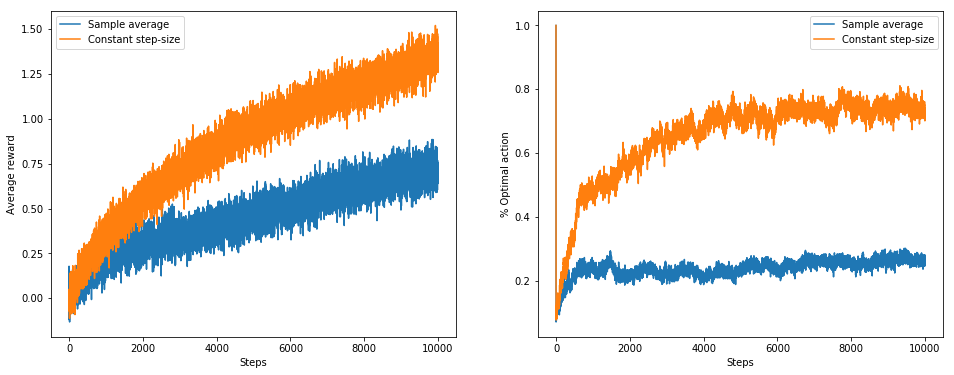

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].plot(sample_average_rewards_average, label='Sample average')
ax[0].plot(constant_step_size_rewards_average, label='Constant step-size')
ax[0].set_xlabel('Steps')
ax[0].set_ylabel('Average reward')
ax[0].legend()

ax[1].plot(sample_average_optimals_average, label='Sample average')
ax[1].plot(constant_step_size_optimals_average, label='Constant step-size')
ax[1].set_xlabel('Steps')
ax[1].set_ylabel('% Optimal action')
ax[1].legend()

Sample average does not perform well on nonstationary problems and does not improve much on choosing the optimal action thus yield a lower average reward.